In [6]:
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.8/bin")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model
from tensorflow.python.client import device_lib 
from keras.optimizers import Adam
from keras import backend as K


In [7]:
tf.__version__

'2.10.0'

In [8]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1144613276012252105
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10197401600
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14900655762290774127
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [9]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
testX = np.load('testX.npy')
testY = np.load('testY.npy')

In [10]:
epochs = 1
model = Sequential()
K.clear_session()



In [11]:
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min', restore_best_weights=True)

model.add(LSTM(units=1024, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

model.fit(trainX, trainY, batch_size=1, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

model.summary()

6821/6821 [==============================] - 120s 17ms/step - loss: 0.6781 - val_loss: 0.6557
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 1024)          4444160   
                                                                 
 dropout (Dropout)           (None, 25, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 512)           3147776   
                                                                 
 dropout_1 (Dropout)         (None, 25, 512)           0         
                                                                 
 lstm_2 (LSTM)               (None, 25, 256)           787456    
                                                                 
 dropout_2 (Dropout)         (None, 25, 256)           0         
                            

In [12]:
results = model.evaluate(testX, testY, batch_size=1)
print('test loss, test acc:', results)

1895/1895 [==============================] - 11s 6ms/step - loss: 0.6638
test loss, test acc: 0.6638248562812805


In [13]:
# 모델의 예측값을 계산합니다.
y_hat = model.predict(testX)

60/60 [==============================] - 2s 7ms/step


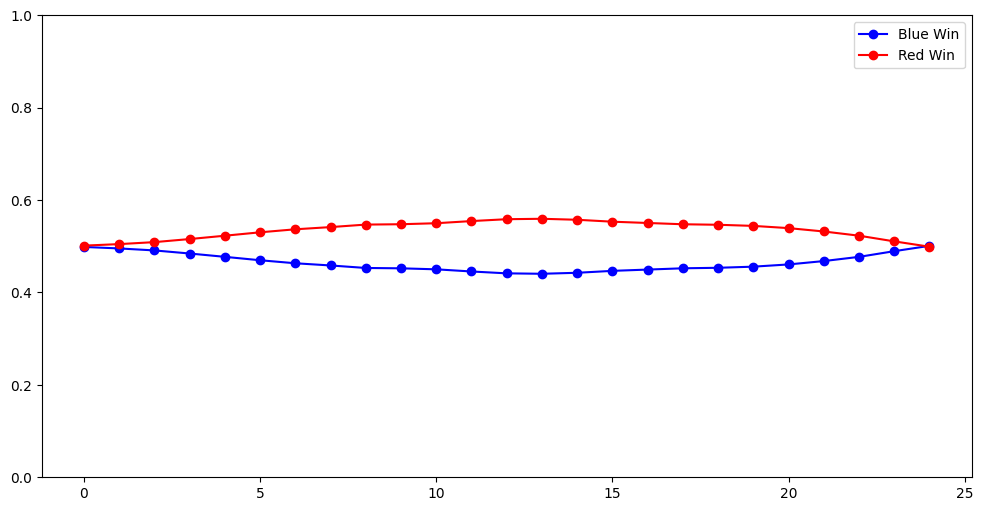

In [46]:
import numpy as np
a_axis = np.arange(0, 25)
prediction_per_minute_mean = None
for i in range(len(testY)):
    if testY[i][0] == 1:
        if prediction_per_minute_mean is None:
            prediction_per_minute_mean = y_hat[i].reshape(1, 25, 1)
        else:
            prediction_per_minute_mean = np.vstack((prediction_per_minute_mean, y_hat[i].reshape(1, 25, 1)))
prediction_per_minute_mean = prediction_per_minute_mean.mean(axis=0)
plt.figure(figsize=(12, 6))
plt.plot(a_axis, prediction_per_minute_mean, 'o-', label='Blue Win', color='blue')
plt.plot(a_axis, [1 - x for x in prediction_per_minute_mean], 'o-', label='Red Win', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()

